In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
%matplotlib inline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import feature_selection as fs
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('epi_r.csv') as f:
    df = pd.read_csv(f)

In [4]:
df.shape

(20052, 680)

### Задача: обучить модель предсказывать рэйтинг блюда

Необходимо сделать следующие шаги:

1) Сделать что-то с пропусками(выбросить или заполнить чем либо)

2) Сделать что-то с дубликатами

3) Проверсти препроцессинг(выделить факторы, нормальзовать факторы)

4) Попробовать добваить новые факторы на основе имеющихся

5) Обучить модель и проверить результаты на тестовой выборке(изначально нужно разделить на тестовыю и обучающуюся)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


#### Из описания видно, что только один столбец содержит в себе строки, а остальные столбцы - числа

In [6]:
df.describe()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.000299,0.000050,0.000848,0.001346,0.000349,...,0.001247,0.026332,0.000050,0.000299,0.014861,0.000150,0.000349,0.001396,0.000948,0.022741
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.017296,0.007062,0.029105,0.036671,0.018681,...,0.035288,0.160123,0.007062,0.017296,0.121001,0.012231,0.018681,0.037343,0.030768,0.149080
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_train, df_test = model_selection.train_test_split(df)

In [8]:
df_train.shape, df_test.shape

((15039, 680), (5013, 680))

In [9]:
sum(df_train.isna().sum() > 0)

4

In [10]:
df_train.isna().sum().sort_values()[-4:]

calories    3070
sodium      3071
protein     3103
fat         3118
dtype: int64

#### calories, protein, fat, sodium -  имеют пропущенные значения

In [11]:
col_with_nan = ['calories', 'protein', 'fat', 'sodium']

### Определим выбросы

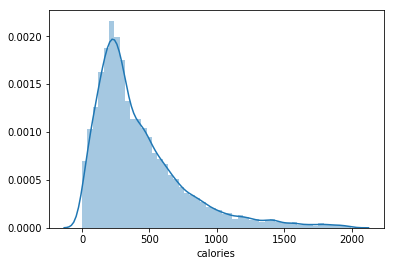

In [12]:
sns.distplot(df_train.calories[df_train.calories < 2000].dropna())

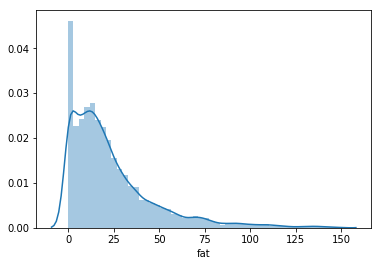

In [13]:
sns.distplot(df_train.fat[df_train.fat < 150].dropna())

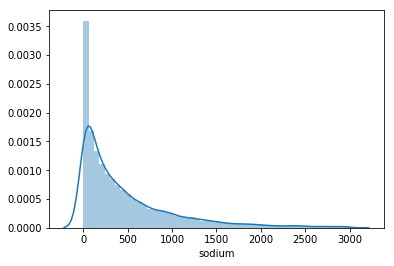

In [14]:
sns.distplot(df_train.sodium[df_train.sodium < 3000].dropna())

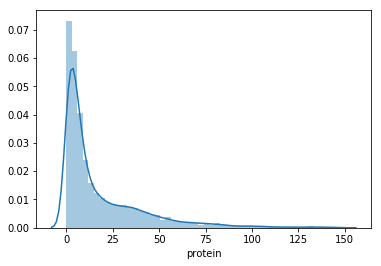

In [15]:
sns.distplot(df_train.protein[df_train.protein < 150].dropna())

Выпишем границу для каждой колонки, значения выше которой мы будем принимать за выбросы

In [16]:
treshholds = [
    ('calories', 2000),
    ('sodium', 3000),
    ('fat', 150),
    ('protein', 150)
]

In [17]:
df_train.shape

(15039, 680)

Удалим выбросы

In [18]:
for col, val in treshholds:
    df_train = df_train[df_train[col] < val]

In [19]:
df_train.shape

(11378, 680)

Заполним все Nan средним значением по каждой колонке

In [20]:
df_train = df_train.fillna(df_train.mean())

In [21]:
df_train.isna().sum().sum()

0

Удалим название блюд, так как они не несут полезной информации

In [22]:
df_train = df_train.drop('title', axis=1)

In [23]:
X = df_train.drop('rating', axis=1)
y = df_train.rating

In [24]:
lr = linear_model.LinearRegression()
lr.fit(X.values, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
lr.predict(X)

array([3.91925001, 4.4883866 , 4.13501174, ..., 3.67842468, 3.98325343,
       3.63336181])

In [27]:
metrics.mean_absolute_error(y, lr.predict(X))

0.780090814097639

In [28]:
from sklearn import feature_selection

In [29]:
print(X.shape)
print(feature_selection.VarianceThreshold(.01).fit_transform(X).shape)

(11378, 678)
(11378, 208)


In [48]:
VT = feature_selection.VarianceThreshold(.01).fit(X)

In [49]:
X = VT.transform(X)
X.shape

(11378, 208)

In [50]:
scaler = preprocessing.StandardScaler()

In [51]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [52]:
X_norm = scaler.transform(X)

In [53]:
X_norm[:,2:3]

array([[ 0.00678585],
       [ 2.28279994],
       [ 0.40071137],
       ...,
       [-0.03698365],
       [-0.29960066],
       [-0.16829216]])

In [54]:
lr1 = linear_model.LinearRegression()
lr1.fit(X_norm, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [55]:
metrics.mean_squared_error(y, lr1.predict(X_norm))

1.4110463193538043

In [69]:
all_losses = []

for k in range(5, 208, 3):
    X_kbest = feature_selection.SelectKBest(
        feature_selection.f_classif, 
        k=k,
    ).fit_transform(
        X_norm,
        y,
    )
    lr = linear_model.LinearRegression()
    standart_scaler = preprocessing.StandardScaler()
    loss = model_selection.cross_val_score(
        lr, 
        standart_scaler.fit_transform(X_kbest),
        y, 
        scoring='neg_mean_absolute_error'
    ).mean()
    print(f"k = {k} neg_mean_absolute_error = {loss}")
    all_losses.append(loss)

k = 5 neg_mean_absolute_error = -0.8264876693275581
k = 8 neg_mean_absolute_error = -0.8243020272043794
k = 11 neg_mean_absolute_error = -0.8297467677460189
k = 14 neg_mean_absolute_error = -0.832816894082983
k = 17 neg_mean_absolute_error = -0.832299600249136
k = 20 neg_mean_absolute_error = -0.8326286907512755
k = 23 neg_mean_absolute_error = -0.8313635755880139
k = 26 neg_mean_absolute_error = -0.8307986271710011
k = 29 neg_mean_absolute_error = -0.8305592814998407
k = 32 neg_mean_absolute_error = -0.8316228706997494
k = 35 neg_mean_absolute_error = -0.8310362580669585
k = 38 neg_mean_absolute_error = -0.8299058420452196
k = 41 neg_mean_absolute_error = -0.8280682920656247
k = 44 neg_mean_absolute_error = -0.8283080506733905
k = 47 neg_mean_absolute_error = -0.8283178035606
k = 50 neg_mean_absolute_error = -0.8277253462340118
k = 53 neg_mean_absolute_error = -0.8279235831095616
k = 56 neg_mean_absolute_error = -0.828000074970641
k = 59 neg_mean_absolute_error = -0.828244015845612
k 

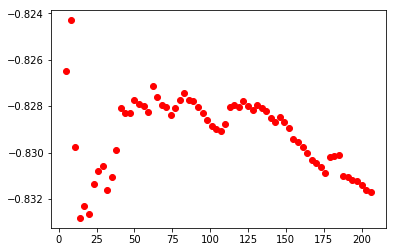

In [70]:
plt.plot(range(5, 208, 3), all_losses, 'ro')
plt.show()

In [71]:
kbest = feature_selection.SelectKBest(
        feature_selection.f_classif, 
        k=8,
    ).fit(
        X_norm,
        y,
    )

In [72]:
X_kbest = kbest.transform(X_norm)

In [73]:
loss = model_selection.cross_val_score(
    linear_model.LinearRegression(), 
    X_kbest,
    y, 
    scoring='neg_mean_absolute_error'
).mean()
print("k =", 8, "neg_mean_absolute_error =", loss)

k = 8 neg_mean_absolute_error = -0.8243020272043794
